### Linear Regression from Scratch

Import libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import torch
import d2l

In the following code snippet, we generate a dataset containing 1 000 examples, each consisting of 2 features sampled from a standard normal distribution. Thus our synthetic dataset will be a matrix *$ X \in \mathbb{R} ^{1000x2} $*

The true parameters generating the dataset will be $\textbf{w} = [2, -3.4]^T$ and $b = 4.2$. Synthetic labels will follow the following linear model with error term $ \epsilon $: $$\textbf{y} = \textbf{X}\textbf{w} +b + \epsilon $$


In [3]:
#@save
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples,len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    
    return X, y.reshape((-1,1))


In [16]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(
    true_w,
    true_b,
    10000)

In [5]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.8342, -0.8385]) 
label: tensor([5.3736])


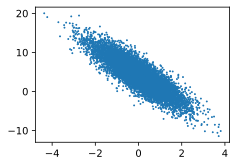

In [6]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1], labels, 1);

Next we define a function to take a minibatch of data of size `batch_size`

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        
        yield features[batch_indices], labels[batch_indices]
        

In [8]:
#hide_output
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.2681,  0.0584],
        [ 1.6767,  1.5700],
        [ 1.1287, -0.9563],
        [-0.9742, -0.0981],
        [ 0.1218,  1.2931],
        [-0.0460,  0.2967],
        [ 0.2075, -0.6811],
        [ 1.6962, -0.2645],
        [-0.5634, -0.4715],
        [ 0.7928,  0.4638]]) 
 tensor([[3.4709],
        [2.2071],
        [9.6991],
        [2.5828],
        [0.0498],
        [3.0908],
        [6.9293],
        [8.4990],
        [4.6556],
        [4.2129]])


Initialize the weights

In [9]:
w = torch.normal(0, 1, (2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [10]:
# @save
def linreg(X, w, b):
    """The linear regression model"""
    return X @ w + b

In [11]:
# @save
def squared_loss(y_hat, y):
    return 0.5 * (y_hat-y.reshape(y_hat.shape))**2

In [12]:
# @save
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param += -lr * param.grad / batch_size
            param.grad.zero_()

In [13]:
### Training loop

* Inititalize parameters ($\mathbf{w}, b$)
* Repeat until done
    * Compute gradient $\textbf{g} \leftarrow \partial_{\mathbf{w}, b} \frac{1}{|B|} \sum_{i \in B} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b) $
    * Update parameters $ (\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}  $

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # Minibatch loss in `X` and `y`
        l = loss(net(X, w, b), y)  
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        # Update parameters using their gradient
        sgd([w, b], lr, batch_size)  
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


In [18]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([4.0579e-04, 7.4625e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([5.2452e-05], grad_fn=<RsubBackward1>)


### Now leveraging PyTorch

In [1]:
#hide
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch.utils import data
import d2l

In [2]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [3]:
# save
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [4]:
next(iter(data_iter))

[tensor([[ 1.2632, -1.4318],
         [-1.2828,  0.5169],
         [ 0.6646, -0.7752],
         [-0.3978, -0.1792],
         [-0.4321,  1.3309],
         [ 0.5222,  0.9050],
         [-0.8075,  0.4358],
         [ 0.3331, -0.1475],
         [ 1.2248,  1.0001],
         [-1.1675,  0.0587]]),
 tensor([[11.5908],
         [-0.1005],
         [ 8.1534],
         [ 4.0223],
         [-1.1992],
         [ 2.1577],
         [ 1.1017],
         [ 5.3629],
         [ 3.2534],
         [ 1.6555]])]

In [41]:
from torch import nn

# Define the model
net = nn.Sequential(nn.Linear(2, 1))

# Initialize model parameters
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# Define the loss function
loss = nn.MSELoss()

# Define the Optimization Algorithm
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [42]:
num_epochs = 3
loss_array = []
for epoch in range(num_epochs):
    for X,y in data_iter:
        l = loss(net(X), y)
        loss_array.append(l.detach().numpy())
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000208
epoch 2, loss 0.000093
epoch 3, loss 0.000093


Y has one axis


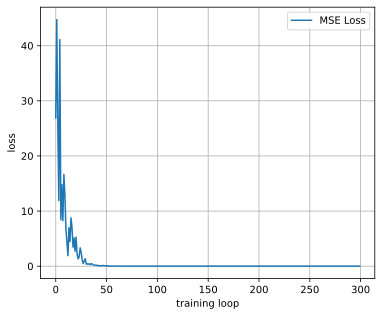

In [43]:
x_for_plot = np.arange(len(loss_array))
y_for_plot = np.array(loss_array)
d2l.plot(x_for_plot, 
         y_for_plot,
         'training loop',
         'loss',
         legend=["MSE Loss"],
         figsize=(6,5))

In [44]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([-7.2241e-05,  5.5385e-04])
error in estimating b: tensor([0.0003])
